# AWS ML Example

## Python, Boto, AWS ML and Horse Racing Tips

Using AWS Machine learning, we will try to predcit if a tipster is going to be correct about a particular horse winning a race.

### Import Libraries

- boto3 -- library for interacting with the AWS APIs.
- matplotlib -- library for graphing
- pandas -- library for data analysis
- numpy -- library for array processing
- sklearn -- library for Python machine learning
- fbprophet -- library for time series forecasting
- datetime/calendar -- libraries for datetime stuff
- json -- library for json formats
- time -- library for time, also used on Gallifrey

In [62]:
import boto3
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, scale, normalize
from sklearn.ensemble import RandomForestClassifier
from fbprophet import Prophet
from datetime import datetime
import json
import calendar
import time
%matplotlib inline

In [63]:
def default(obj):
    """Default JSON serializer."""
    import calendar, datetime

    if isinstance(obj, datetime.datetime):
        if obj.utcoffset() is not None:
            obj = obj - obj.utcoffset()
        millis = int(
            calendar.timegm(obj.timetuple()) * 1000 +
            obj.microsecond / 1000
        )
        return millis
    raise TypeError('Not sure how to serialize %s' % (obj,))

### Load the training data

Our training data includes details and results for tips in the past.

In [64]:
tips_df = pd.read_csv("tip_results.csv", encoding='latin1')

### View training data

- View Columns

In [65]:
tips_df.columns

Index(['horse', 'track', 'race_number', 'race_date', 'tipster',
       'next_best_bet', 'value_bet', 'best_bet', 'career_3rds',
       'spells_secondup_3rd', 'career_2nds', 'spells_firstup_1st',
       'spells_firstup_place', 'spells_thirdup_odds', 'spells_thirdup_1st',
       'career_places', 'spells_secondup_1st', 'earnings',
       'twelve_months_wins', 'spells_thirdup_roi', 'twelve_months_odds',
       'spells_thirdup_place', 'twelve_months_1sts', 'career_1sts',
       'career_roi', 'twelve_months_starts', 'spells_thirdup_3rd',
       'twelve_months_2nds', 'spells_thirdup_win', 'career_wins',
       'spells_secondup_roi', 'spells_secondup_starts', 'career_odds',
       'spells_secondup_2nd', 'age_in_years', 'career_starts',
       'spells_firstup_win', 'spells_firstup_2nd', 'rating',
       'spells_secondup_win', 'twelve_months_roi', 'spells_secondup_place',
       'spells_thirdup_starts', 'twelve_months_3rds', 'spells_firstup_starts',
       'spells_secondup_odds', 'twelve_months_

- View Data Types

In [66]:
tips_df.dtypes

horse                      object
track                      object
race_number                 int64
race_date                  object
tipster                     int64
next_best_bet                bool
value_bet                    bool
best_bet                     bool
career_3rds               float64
spells_secondup_3rd       float64
career_2nds               float64
spells_firstup_1st        float64
spells_firstup_place      float64
spells_thirdup_odds       float64
spells_thirdup_1st        float64
career_places             float64
spells_secondup_1st       float64
earnings                  float64
twelve_months_wins        float64
spells_thirdup_roi        float64
twelve_months_odds        float64
spells_thirdup_place      float64
twelve_months_1sts        float64
career_1sts               float64
career_roi                float64
twelve_months_starts      float64
spells_thirdup_3rd        float64
twelve_months_2nds        float64
spells_thirdup_win        float64
career_wins   

- View First 5 Records

In [67]:
tips_df.head(n=5)

,horse,track,race_number,race_date,tipster,next_best_bet,value_bet,best_bet,career_3rds,spells_secondup_3rd,...,spells_thirdup_starts,twelve_months_3rds,spells_firstup_starts,spells_secondup_odds,twelve_months_places,spells_firstup_odds,spells_firstup_roi,spells_firstup_3rd,spells_thirdup_2nd,money
0,Wazamba,Moonee Valley,2,2016-03-14,1,False,False,False,1.0,0.0,...,0.0,1.0,0.0,2.6,0.75,0.00,100.0,1.0,2.0,False
1,Sistine Star,Ballarat,8,2016-03-15,1,False,False,False,5.0,2.0,...,1.0,2.0,0.0,0.0,0.29,0.00,100.0,2.0,0.0,False
2,Aspidistra,Ballarat,5,2016-03-15,1,False,False,False,1.0,0.0,...,1.0,0.0,0.0,3.7,0.40,0.00,100.0,1.0,0.0,True
3,Montana,Ballarat,2,2016-03-15,1,False,False,False,2.0,0.0,...,0.0,2.0,0.0,0.0,0.67,0.00,100.0,1.0,1.0,False
4,Prompt Return,Gosford,7,2016-03-17,1,False,False,False,1.0,0.0,...,0.0,1.0,2.0,11.3,0.50,2.48,24.0,0.0,2.0,False


### Convert objects types

In [68]:
tips_df['race_date'] = pd.to_datetime(tips_df['race_date'], dayfirst=True)

### Investigate Tipster Performance

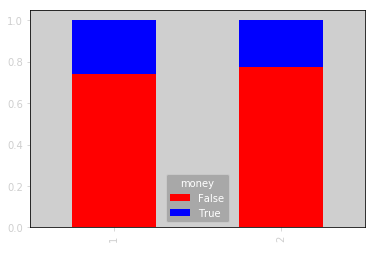

In [69]:
cross_tab = pd.crosstab(tips_df['tipster'], tips_df['money'], margins=True)
def perConvert(ser):
    return ser/float(ser[-1])
cross_tab1 = cross_tab.apply(perConvert, axis=1)
cross_tab1.iloc[:-1,:-1].plot(kind='bar', stacked=True, color=['red', 'blue'], grid=False)

In [70]:
print(tips_df['money'].value_counts())
print('~'*30)
print(tips_df['money'].value_counts()/tips_df.money.shape[0]*100)

False    5555
True     1655
Name: money, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
False    77.04577
True     22.95423
Name: money, dtype: float64


### Split the two tipsters into seperate DataFrames

In [71]:
tipster_1 = tips_df.loc[tips_df['tipster'] == 1]
tipster_2 = tips_df.loc[tips_df['tipster'] == 2]

### Create a new dataset for fbprophet

In [72]:
count = 1000
tipster1_forecast_data = []
tipster2_forecast_data = []
for idx, val in enumerate(tipster_1['money']):
    if val:
        count += 1
        tipster1_forecast_data.append({"ds":datetime.fromordinal(idx+730000),"y":count})
    else:
        count -= 1
        tipster1_forecast_data.append({"ds":datetime.fromordinal(idx+730000),"y":count})      
count = 1000
forecast_data = []
for idx, val in enumerate(tipster_2['money']):
    if val:
        count += 1
        tipster2_forecast_data.append({"ds":datetime.fromordinal(idx+730000),"y":count})
    else:
        count -= 1
        tipster2_forecast_data.append({"ds":datetime.fromordinal(idx+730000),"y":count})    

In [73]:
print(len(tipster1_forecast_data))
print(len(tipster2_forecast_data))

1354
5856


### Fit data to Prophet

In [74]:
tipster1_m = Prophet()
tipster1_m.fit(pd.DataFrame(tipster1_forecast_data));
tipster2_m = Prophet()
tipster2_m.fit(pd.DataFrame(tipster2_forecast_data));

In [75]:
tipster1_future = tipster1_m.make_future_dataframe(periods=1000)
tipster2_future = tipster2_m.make_future_dataframe(periods=1000)

### Predict next period

In [76]:
tipster1_forecast = tipster1_m.predict(tipster1_future)
tipster2_forecast = tipster2_m.predict(tipster2_future)

### Plot Predictions

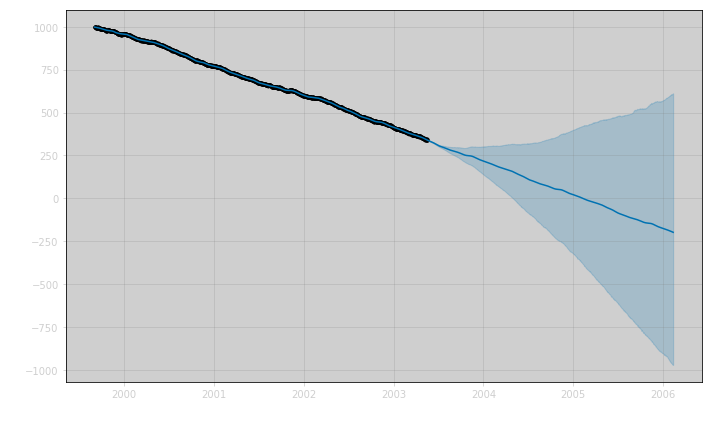

In [77]:
tipster1_m.plot(tipster1_forecast);

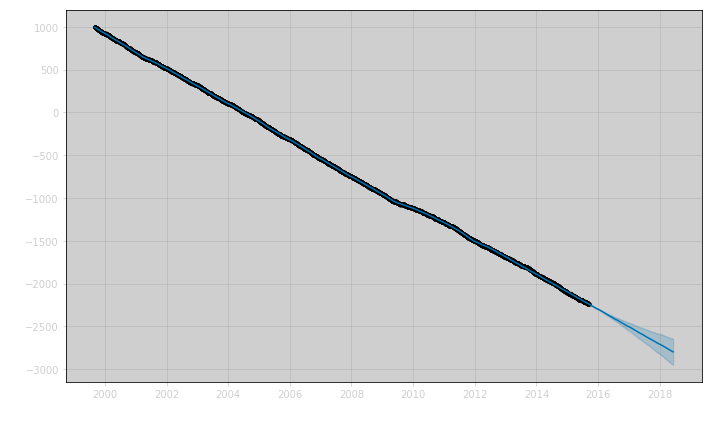

In [78]:
tipster2_m.plot(tipster2_forecast);

### Upload Training Data to S3

In [79]:
s3.Bucket('ml-talk').upload_file("tip_results.csv","tip_results.csv") 

INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Resetting dropped connection: ml-talk.s3.amazonaws.com


### Create AWS ML Data Data Scheme

In [80]:
data_scheme = {
    "version": "1.0",
    "targetFieldName": "money",
    "dataFormat": "CSV",
    "dataFileContainsHeader": True,
    "attributes": [{
        "fieldName": "horse",
        "fieldType": "CATEGORICAL"
    }, 
    {
        "fieldName": "track",
        "fieldType": "CATEGORICAL"
    },
    {
        "fieldName": "race_number",
        "fieldType": "CATEGORICAL"
    },        
    {
        "fieldName": "race_date",
        "fieldType": "CATEGORICAL"
    },
    {
        "fieldName": "tipster",
        "fieldType": "CATEGORICAL"
    },
    {
        "fieldName": "next_best_bet",
        "fieldType": "BINARY"
    },
    {
        "fieldName": "value_bet",
        "fieldType": "BINARY"
    },
    {
        "fieldName": "best_bet",
        "fieldType": "BINARY"
    },
    {
        "fieldName": "career_3rds",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "spells_secondup_3rd",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "career_2nds",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "spells_firstup_1st",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "spells_firstup_place",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "spells_thirdup_odds",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "spells_thirdup_1st",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "career_places",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "spells_secondup_1st",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "earnings",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "twelve_months_wins",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "spells_thirdup_roi",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "twelve_months_odds",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "spells_thirdup_place",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "twelve_months_1sts",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "career_1sts",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "career_roi",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "twelve_months_starts",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "spells_thirdup_3rd",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "twelve_months_2nds",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "spells_thirdup_win",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "career_wins",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "spells_secondup_roi",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "spells_secondup_starts",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "career_odds",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "spells_secondup_2nd",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "age_in_years",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "career_starts",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "spells_firstup_win",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "spells_firstup_2nd",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "rating",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "spells_secondup_win",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "twelve_months_roi",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "trainer",
        "fieldType": "CATEGORICAL"
    },
    {
        "fieldName": "spells_secondup_place",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "spells_thirdup_starts",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "twelve_months_3rds",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "spells_firstup_starts",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "spells_secondup_odds",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "twelve_months_places",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "spells_firstup_odds",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "spells_firstup_roi",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "spells_firstup_3rd",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "spells_thirdup_2nd",
        "fieldType": "NUMERIC"
    },
    {
        "fieldName": "money",
        "fieldType": "BINARY"
    }   
    ]
}

### Create Boto object for Machine Learning

In [81]:
ml_client = boto3.client('machinelearning')

INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): machinelearning.us-east-1.amazonaws.com


### Create Training Data Set - First 70% of Records

In [ ]:
spec = {
    "DataLocationS3": 's3://ml-talk/tip_results.csv',
    "DataRearrangement": json.dumps({
        "splitting": {
            "percentBegin": 0,
            "percentEnd": 70
        }
    }),
    "DataSchema": json.dumps(data_scheme),
}

response = ml_client.create_data_source_from_s3(
    DataSourceId='mltalk-tips-train-%s' % calendar.timegm(time.gmtime()),
    DataSpec=spec,
    DataSourceName='mltalk-tips-train-%s' % calendar.timegm(time.gmtime()),
    ComputeStatistics=True
)

train_data_source_id = response['DataSourceId']

### Create Testing Data Set -- Last 30% of Records

In [ ]:
spec['DataRearrangement'] = json.dumps({
    "splitting": {
        "percentBegin": 70,
        "percentEnd": 100
    }
})

response = ml_client.create_data_source_from_s3(
    DataSourceId='mltalk-tips-test-%s' % calendar.timegm(time.gmtime()),
    DataSpec=spec,
    DataSourceName='mltalk-tips-test-%s' % calendar.timegm(time.gmtime()),
    ComputeStatistics=True
)
test_data_source_id = response['DataSourceId']

### Create ML Model

In [83]:
response = ml_client.create_ml_model(
    MLModelId='ml-talk-model-%s' % calendar.timegm(time.gmtime()),
    MLModelName='ml-talk-model-%s' % calendar.timegm(time.gmtime()),
    MLModelType='BINARY',
    TrainingDataSourceId=train_data_source_id
)
print(json.dumps(response, indent=4)) 
ml_model_id = response['MLModelId']

### Evalutate ML Model

In [85]:
response = ml_client.create_evaluation(
    EvaluationId='ml-talk-eval-%s' % calendar.timegm(time.gmtime()),
    EvaluationName='ml-talk-eval-%s' % calendar.timegm(time.gmtime()),
    MLModelId=ml_model_id,
    EvaluationDataSourceId=test_data_source_id
)
print(json.dumps(response, indent=4))
evaluation_id = response['EvaluationId']

INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Resetting dropped connection: machinelearning.us-east-1.amazonaws.com


### Get Evaluation Results

In [87]:
response = ml_client.get_evaluation(
    EvaluationId=evaluation_id
)
print(json.dumps(response, indent=4, default=default))
accuracy = response['PerformanceMetrics']['Properties']['BinaryAUC']

INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Resetting dropped connection: machinelearning.us-east-1.amazonaws.com


In [93]:
print("Area Under Curve: %s" % accuracy)

Area Under Curve: 0.8400417041980808


### Create Real Time Endpoint

In [94]:
response = ml_client.create_realtime_endpoint(
    MLModelId=ml_model_id
)
print(json.dumps(response, indent=4, default=default))
realtime_endpoint = response['RealtimeEndpointInfo']['EndpointUrl']

INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Resetting dropped connection: machinelearning.us-east-1.amazonaws.com


### Load Tips to Predict

In [98]:
tips_to_predict = pd.read_csv('to_predict.csv')

In [99]:
len(tips_to_predict)

44

In [100]:
tips_to_predict.head(n=3)

,twelve_months_2nds,spells_secondup_place,spells_firstup_starts,career_3rds,track,spells_firstup_win,best_bet,spells_thirdup_odds,spells_secondup_win,career_1sts,...,spells_secondup_roi,twelve_months_odds,twelve_months_roi,spells_thirdup_place,spells_thirdup_win,spells_secondup_3rd,twelve_months_starts,race_date,spells_firstup_3rd,race_time
0,0.0,1.0,0.0,5.0,Pinjarra,0.0,False,0.0,0.0,0.0,...,100.0,0.0,1.0,1.0,0.0,2.0,7.0,2017-03-09,1.0,NaN
1,0.0,0.0,0.0,0.0,Pinjarra,0.0,False,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-03-09,0.0,NaN
2,1.0,0.0,0.0,0.0,Pinjarra,0.0,False,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2017-03-09,0.0,NaN


### Predict Tips

In [120]:
all_predictions = []
for idx, tip in tips_to_predict.iterrows():
    tip_dict = tip.to_dict()
    for key in tip_dict:
        tip_dict[key] = str(tip_dict[key])

    response = ml_client.predict(
        MLModelId=ml_model_id,
        Record=tip_dict,
        PredictEndpoint=realtime_endpoint
    )
    all_predictions.append(response['Prediction']['predictedLabel'])
    print("Track: %s\tRace Num: %s\tHorse: %s\tPrediction: %s Score: %s" % (tip['track'], tip['race_number'], tip['horse'], response['Prediction']['predictedLabel'], response['Prediction']['predictedScores'][response['Prediction']['predictedLabel']]))

INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (6): realtime.machinelearning.us-east-1.amazonaws.com


Track: Pinjarra	Race Num: 1	Horse: Senorita Bonita	Prediction: 0 Score: 0.005035972688347101
Track: Pinjarra	Race Num: 2	Horse: Bold Victory	Prediction: 0 Score: 0.16532261669635773
Track: Pinjarra	Race Num: 3	Horse: Blackline	Prediction: 0 Score: 0.011883668601512909
Track: Pinjarra	Race Num: 4	Horse: Golgotha	Prediction: 0 Score: 0.0025537314359098673
Track: Pinjarra	Race Num: 5	Horse: At The Ready	Prediction: 1 Score: 0.5519466400146484
Track: Pinjarra	Race Num: 6	Horse: Universal Moon	Prediction: 0 Score: 0.005886865314096212
Track: Pinjarra	Race Num: 7	Horse: Mega Minx	Prediction: 0 Score: 0.23770137131214142
Track: Pinjarra	Race Num: 8	Horse: Salty	Prediction: 0 Score: 0.07234450429677963
Track: Muswellbrook	Race Num: 1	Horse: Miss Victa	Prediction: 0 Score: 0.26420512795448303
Track: Muswellbrook	Race Num: 2	Horse: Gone To Paris	Prediction: 0 Score: 0.006547232624143362
Track: Muswellbrook	Race Num: 3	Horse: Gai’s Quest	Prediction: 0 Score: 0.4704824388027191
Track: Muswellbrook

### Make some bets

In [118]:
for idx, tip in tips_to_predict.iterrows():
    if all_predictions[idx] == '1':
            print("Track: %s\tRace Num: %s\tHorse: %s" % (tip['track'], tip['race_number'], tip['horse']))

Track: Pinjarra	Race Num: 5	Horse: At The Ready
Track: Seymour	Race Num: 1	Horse: Pat’s Lad


#### Seymour Race 1 Results:

1st - 5 Bouffon

2nd - 7 Fashionedinheaven

3rd - 2 Pat's Lad				

## Other Links

- https://mljar.com/ -- Powered by EC2, upload your dataset and receive back scikit-learn models with tuned params
